In [2]:
import pandas as pd
from sqlalchemy import create_engine
from scipy.stats import linregress
import numpy as np
from sklearn import datasets
import psycopg2
import matplotlib.pyplot as plt
from configparser import ConfigParser


Extract CSV files into DataFrames

In [3]:
netflix_file = "netflix_data_clean.csv"
netflix_df = pd.read_csv(netflix_file)
netflix_df.head()

,Unnamed: 0,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,4,80125979,Movie,#realityhigh,Fernando Lebrija,"Nesta Cooper, Kate Walsh, John Michael Higgins...",United States,"September 8, 2017",2017,TV-14,99 min,Comedies,When nerdy high schooler Dani finally attracts...
1,20,80060297,Movie,Manhattan Romance,Tom O'Brien,"Tom O'Brien, Katherine Waterston, Caitlin Fitz...",United States,"September 8, 2017",2014,TV-14,98 min,"Comedies, Independent Movies, Romantic Movies",A filmmaker working on a documentary about lov...
2,23,70304988,Movie,Stonehearst Asylum,Brad Anderson,"Kate Beckinsale, Jim Sturgess, David Thewlis, ...",United States,"September 8, 2017",2014,PG-13,113 min,"Horror Movies, Thrillers","In 1899, a young doctor arrives at an asylum f..."
3,24,80057700,Movie,The Runner,Austin Stark,"Nicolas Cage, Sarah Paulson, Connie Nielsen, W...",United States,"September 8, 2017",2015,R,90 min,"Dramas, Independent Movies",A New Orleans politician finds his idealistic ...
4,25,80045922,Movie,6 Years,Hannah Fidell,"Taissa Farmiga, Ben Rosenfield, Lindsay Burdge...",United States,"September 8, 2015",2015,NR,80 min,"Dramas, Independent Movies, Romantic Movies",As a volatile young couple who have been toget...


In [4]:
omdb_file = "omdb_data_clean.csv"
omdb_df = pd.read_csv(omdb_file)
omdb_df.head()

,Unnamed: 0,title,genre,language,awards,metascore,boxoffice,production,imdbrating,imdbvotes,imdbid
0,1,Manhattan Romance,"Comedy, Drama, Romance",English,3 wins.,NaN,NaN,Beacon Films Inc.,5.5,"1,122",tt2608324
1,2,Stonehearst Asylum,"Drama, Horror, Thriller",English,1 win & 1 nomination.,52.0,NaN,Millenium Entertainment,6.8,"48,493",tt1772264
2,3,The Runner,Drama,English,NaN,39.0,NaN,Alchemy,4.7,"4,768",tt3687398
3,4,6 Years,"Drama, Romance",English,4 nominations.,53.0,NaN,NaN,5.6,"10,784",tt3799372
4,5,Sierra Burgess Is a Loser,"Comedy, Drama, Romance",English,2 nominations.,60.0,NaN,Netflix,5.9,"31,443",tt3120280


In [5]:
tmdb_file = "tmdb_data_clean.csv"
tmdb_df = pd.read_csv(tmdb_file)
tmdb_df.head()

,Unnamed: 0,title,original_title,popularity,vote_count,vote_average,poster_path
0,1,Manhattan Romance,Manhattan Romance,3.919,24,4.8,na
1,2,Stonehearst Asylum,Stonehearst Asylum,20.826,817,6.7,https://image.tmdb.org/t/p/w500/fZxGCCQ0NAtrae...
2,3,The Runner,The Runner,9.011,104,4.8,https://image.tmdb.org/t/p/w500/uIxFfrGlKEHJgk...
3,4,6 Years,6 Years,6.515,594,5.5,na
4,5,Sierra Burgess Is a Loser,Sierra Burgess Is a Loser,19.091,2689,6.4,https://image.tmdb.org/t/p/w500/vjnHRySiVM4YcB...


Transform Netflix and the Open Movie DB DataFrames

In [6]:
# Create a filtered on the Netflix dataframe from specific columns
netflix_columns = ["show_id", "title", "director", "cast", "release_year", "listed_in", "rating", "duration", "description"]
netflix_transformed= netflix_df[netflix_columns].copy()

# Rename the column headers
netflix_transformed = netflix_transformed.rename(columns={"show_id": "id",
                                                          "listed_in": "netflix_genre", 
                                                          "release_year": "year_released", 
                                                          "cast":"cast_members"})

# Clean the data by dropping duplicates and setting the index
netflix_transformed.drop_duplicates("id", inplace=True)
netflix_transformed.set_index("id", inplace=True)

netflix_transformed.head()

,title,director,cast_members,year_released,netflix_genre,rating,duration,description
id,,,,,,,,
80125979,#realityhigh,Fernando Lebrija,"Nesta Cooper, Kate Walsh, John Michael Higgins...",2017,Comedies,TV-14,99 min,When nerdy high schooler Dani finally attracts...
80060297,Manhattan Romance,Tom O'Brien,"Tom O'Brien, Katherine Waterston, Caitlin Fitz...",2014,"Comedies, Independent Movies, Romantic Movies",TV-14,98 min,A filmmaker working on a documentary about lov...
70304988,Stonehearst Asylum,Brad Anderson,"Kate Beckinsale, Jim Sturgess, David Thewlis, ...",2014,"Horror Movies, Thrillers",PG-13,113 min,"In 1899, a young doctor arrives at an asylum f..."
80057700,The Runner,Austin Stark,"Nicolas Cage, Sarah Paulson, Connie Nielsen, W...",2015,"Dramas, Independent Movies",R,90 min,A New Orleans politician finds his idealistic ...
80045922,6 Years,Hannah Fidell,"Taissa Farmiga, Ben Rosenfield, Lindsay Burdge...",2015,"Dramas, Independent Movies, Romantic Movies",NR,80 min,As a volatile young couple who have been toget...


In [7]:
 # Create a filtered on the Open Move DB dataframe from specific columns
omdb_columns = ["title", "genre", "language", "awards", "production", "imdbid", "imdbrating", "metascore", "boxoffice"]
omdb_transformed= omdb_df[omdb_columns].copy()

omdb_transformed = omdb_transformed.rename(columns={"genre": "omdb_genre"})

omdb_transformed["boxoffice"]=omdb_transformed["boxoffice"].str.replace('$', '')
omdb_transformed["boxoffice"]=omdb_transformed["boxoffice"].str.replace(',', '')
#omdb_transformed["boxoffice"]=omdb_transformed["boxoffice"].astype(float)

# Clean the data by dropping duplicates and setting the index
omdb_transformed.drop_duplicates("imdbid", inplace=True)
omdb_transformed.set_index("imdbid", inplace=True)

omdb_transformed

,title,omdb_genre,language,awards,production,imdbrating,metascore,boxoffice
imdbid,,,,,,,,
tt2608324,Manhattan Romance,"Comedy, Drama, Romance",English,3 wins.,Beacon Films Inc.,5.5,NaN,NaN
tt1772264,Stonehearst Asylum,"Drama, Horror, Thriller",English,1 win & 1 nomination.,Millenium Entertainment,6.8,52.0,NaN
tt3687398,The Runner,Drama,English,NaN,Alchemy,4.7,39.0,NaN
tt3799372,6 Years,"Drama, Romance",English,4 nominations.,NaN,5.6,53.0,NaN
tt3120280,Sierra Burgess Is a Loser,"Comedy, Drama, Romance",English,2 nominations.,Netflix,5.9,60.0,NaN
...,...,...,...,...,...,...,...,...
tt5420376,Riverdale,"Crime, Drama, Mystery, Romance",English,30 wins & 39 nominations.,na,7.1,NaN,na
tt3107288,The Flash,"Action, Adventure, Drama, Sci-Fi",English,Nominated for 1 Primetime Emmy. Another 26 win...,na,7.8,NaN,na
tt2193021,Arrow,"Action, Adventure, Crime, Drama, Mystery, Sci-Fi",English,21 wins & 82 nominations.,na,7.6,NaN,na


In [8]:
 # Create a filtered on the Open Move DB dataframe from specific columns
tmdb_columns = ["title", "original_title", "popularity", "vote_count", "vote_average", "poster_path"]
tmdb_transformed= tmdb_df[tmdb_columns].copy()

tmdb_transformed.head()

,title,original_title,popularity,vote_count,vote_average,poster_path
0,Manhattan Romance,Manhattan Romance,3.919,24,4.8,na
1,Stonehearst Asylum,Stonehearst Asylum,20.826,817,6.7,https://image.tmdb.org/t/p/w500/fZxGCCQ0NAtrae...
2,The Runner,The Runner,9.011,104,4.8,https://image.tmdb.org/t/p/w500/uIxFfrGlKEHJgk...
3,6 Years,6 Years,6.515,594,5.5,na
4,Sierra Burgess Is a Loser,Sierra Burgess Is a Loser,19.091,2689,6.4,https://image.tmdb.org/t/p/w500/vjnHRySiVM4YcB...


Create a DB connection

In [8]:
connection_string = "postgres:postgres@localhost:5432/movies_db"
engine = create_engine(f'postgresql://{connection_string}')

In [9]:
# Confirm tables were created
engine.table_names()

['omdb', 'netflix', 'tmdb']

Load Transformed DF data into the DB

In [10]:
netflix_transformed.to_sql(name='netflix', con=engine, if_exists='append', index=True)

In [11]:
omdb_transformed.to_sql(name='omdb', con=engine, if_exists='append', index=True)

In [12]:
tmdb_transformed.to_sql(name='tmdb', con=engine, if_exists='append', index=False)

In [9]:
merge_table1 = pd.merge(netflix_transformed, omdb_transformed, on="title", how="outer")
merge_table1.head()

,title,director,cast_members,year_released,netflix_genre,rating,duration,description,omdb_genre,language,awards,production,imdbrating,metascore,boxoffice
0,#realityhigh,Fernando Lebrija,"Nesta Cooper, Kate Walsh, John Michael Higgins...",2017.0,Comedies,TV-14,99 min,When nerdy high schooler Dani finally attracts...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Manhattan Romance,Tom O'Brien,"Tom O'Brien, Katherine Waterston, Caitlin Fitz...",2014.0,"Comedies, Independent Movies, Romantic Movies",TV-14,98 min,A filmmaker working on a documentary about lov...,"Comedy, Drama, Romance",English,3 wins.,Beacon Films Inc.,5.5,NaN,NaN
2,Stonehearst Asylum,Brad Anderson,"Kate Beckinsale, Jim Sturgess, David Thewlis, ...",2014.0,"Horror Movies, Thrillers",PG-13,113 min,"In 1899, a young doctor arrives at an asylum f...","Drama, Horror, Thriller",English,1 win & 1 nomination.,Millenium Entertainment,6.8,52.0,NaN
3,The Runner,Austin Stark,"Nicolas Cage, Sarah Paulson, Connie Nielsen, W...",2015.0,"Dramas, Independent Movies",R,90 min,A New Orleans politician finds his idealistic ...,Drama,English,NaN,Alchemy,4.7,39.0,NaN
4,6 Years,Hannah Fidell,"Taissa Farmiga, Ben Rosenfield, Lindsay Burdge...",2015.0,"Dramas, Independent Movies, Romantic Movies",NR,80 min,As a volatile young couple who have been toget...,"Drama, Romance",English,4 nominations.,NaN,5.6,53.0,NaN


In [10]:
final_table = pd.merge(merge_table1, tmdb_transformed, on="title", how="outer")
final_table_clean = final_table.drop_duplicates("title")
final_table_clean

,title,director,cast_members,year_released,netflix_genre,rating,duration,description,omdb_genre,language,awards,production,imdbrating,metascore,boxoffice,original_title,popularity,vote_count,vote_average,poster_path
0,#realityhigh,Fernando Lebrija,"Nesta Cooper, Kate Walsh, John Michael Higgins...",2017.0,Comedies,TV-14,99 min,When nerdy high schooler Dani finally attracts...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Manhattan Romance,Tom O'Brien,"Tom O'Brien, Katherine Waterston, Caitlin Fitz...",2014.0,"Comedies, Independent Movies, Romantic Movies",TV-14,98 min,A filmmaker working on a documentary about lov...,"Comedy, Drama, Romance",English,3 wins.,Beacon Films Inc.,5.5,NaN,NaN,Manhattan Romance,3.919,24.0,4.8,na
2,Stonehearst Asylum,Brad Anderson,"Kate Beckinsale, Jim Sturgess, David Thewlis, ...",2014.0,"Horror Movies, Thrillers",PG-13,113 min,"In 1899, a young doctor arrives at an asylum f...","Drama, Horror, Thriller",English,1 win & 1 nomination.,Millenium Entertainment,6.8,52.0,NaN,Stonehearst Asylum,20.826,817.0,6.7,https://image.tmdb.org/t/p/w500/fZxGCCQ0NAtrae...
3,The Runner,Austin Stark,"Nicolas Cage, Sarah Paulson, Connie Nielsen, W...",2015.0,"Dramas, Independent Movies",R,90 min,A New Orleans politician finds his idealistic ...,Drama,English,NaN,Alchemy,4.7,39.0,NaN,The Runner,9.011,104.0,4.8,https://image.tmdb.org/t/p/w500/uIxFfrGlKEHJgk...
4,6 Years,Hannah Fidell,"Taissa Farmiga, Ben Rosenfield, Lindsay Burdge...",2015.0,"Dramas, Independent Movies, Romantic Movies",NR,80 min,As a volatile young couple who have been toget...,"Drama, Romance",English,4 nominations.,NaN,5.6,53.0,NaN,6 Years,6.515,594.0,5.5,na
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1567,Emmanuelle Through Time: Emmanuelle's Supernat...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Emmanuelle Through Time: Emmanuelle's Supernat...,9.649,2.0,8.3,na
1568,DC's Legends of Tomorrow: Their Time Is Now,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DC's Legends of Tomorrow: Their Time Is Now,2.540,24.0,6.7,na
1569,Archie: To Riverdale and Back Again,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Archie: To Riverdale and Back Again,2.478,9.0,6.1,https://image.tmdb.org/t/p/w500/5VeJ2FNAg2SGam...
1570,Ricki and the Flash,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Ricki and the Flash,11.206,521.0,5.8,https://image.tmdb.org/t/p/w500/l7Mx2KUT6BlD5v...


In [11]:
box_office_movies = final_table_clean.dropna(subset=["boxoffice"])
box_office_movies = box_office_movies.loc[box_office_movies["boxoffice"]!='na']
box_office_movies["boxoffice"] = box_office_movies["boxoffice"].astype(float)

The r-squared is: 0.027498124684498783


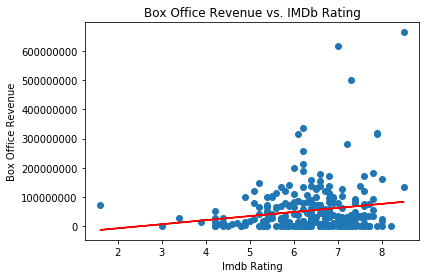

In [12]:
x_values = box_office_movies['imdbrating']
y_values = box_office_movies['boxoffice']
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(0,50),fontsize=15,color="red")
plt.title('Box Office Revenue vs. IMDb Rating')
plt.xlabel('Imdb Rating')
plt.ylabel('Box Office Revenue')
#Turn off the scientific notation (ie8)
plt.ticklabel_format(style="Plain")
print(f"The r-squared is: {rvalue**2}")
plt.show()

In [12]:
box_office_popularity = box_office_movies.dropna(subset=["popularity"])
box_office_popularity

,title,director,cast_members,year_released,netflix_genre,rating,duration,description,omdb_genre,language,awards,production,imdbrating,metascore,boxoffice,original_title,popularity,vote_count,vote_average,poster_path
7,Carrie Pilby,Susan Johnson,"Bel Powley, Nathan Lane, Vanessa Bayer, Gabrie...",2016.0,"Comedies, Dramas",TV-14,98 min,A socially awkward 19-year-old genius makes bi...,"Comedy, Drama",English,1 win & 2 nominations.,The Orchard,6.6,52.0,19025.0,Carrie Pilby,7.934,206.0,7.2,https://image.tmdb.org/t/p/w500/IHuNvCTOsSox1G...
10,Black Panther,Ryan Coogler,"Chadwick Boseman, Michael B. Jordan, Lupita Ny...",2018.0,"Action & Adventure, Sci-Fi & Fantasy",PG-13,135 min,"T'Challa, the superpowered new leader of the h...","Action, Adventure, Sci-Fi","English, Swahili, Nama, Xhosa, Korean",Won 3 Oscars. Another 109 wins & 265 nominations.,Marvel Studios,7.3,88.0,501105037.0,Black Panther,51.678,14711.0,7.4,https://image.tmdb.org/t/p/w500/uxzzxijgPIY7sl...
16,In the Shadow of the Moon,Jim Mickle,"Boyd Holbrook, Michael C. Hall, Cleopatra Cole...",2019.0,"Dramas, Sci-Fi & Fantasy, Thrillers",TV-MA,116 min,A Philadelphia detective slowly unravels as he...,"Crime, Mystery, Sci-Fi, Thriller",English,NaN,ThinkFilm,6.2,48.0,941775.0,In the Shadow of the Moon,14.810,552.0,6.2,https://image.tmdb.org/t/p/w500/5DSVYlKwEzGBxT...
29,The Bad Batch,Ana Lily Amirpour,"Suki Waterhouse, Jason Momoa, Keanu Reeves, Ji...",2016.0,"Dramas, Independent Movies, Thrillers",R,119 min,"Banished to a wasteland of undesirables, a you...","Drama, Horror, Romance, Sci-Fi",English,1 win & 3 nominations.,NEON,5.3,62.0,180851.0,The Bad Batch,13.327,594.0,5.2,https://image.tmdb.org/t/p/w500/7o14VaMphEIzPw...
65,Turbo,David Soren,"Ben Schwartz, Bill Hader, Luis Guzmán, Snoop D...",2013.0,"Children & Family Movies, Comedies",PG,96 min,A speed-obsessed snail who dreams of being the...,"Animation, Adventure, Comedy, Family, Sci-Fi, ...",English,1 win & 13 nominations.,DreamWorks Animation,6.4,58.0,81100000.0,Turbo,18.674,2029.0,6.1,https://image.tmdb.org/t/p/w500/lDARMqluCrWaFg...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1344,Iron Man,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Action, Adventure, Sci-Fi","Hungarian, Kurdish, Hindi, English, Persian, U...",Nominated for 2 Oscars. Another 21 wins & 65 n...,Paramount Pictures,7.9,79.0,318298180.0,Iron Man,56.235,17896.0,7.6,https://image.tmdb.org/t/p/w500/zuxaH2oakoDyo6...
1373,Benji: Off the Leash!,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Drama, Family",English,1 win.,Mulberry Square Releasing,4.9,49.0,3700000.0,Benji: Off the Leash!,3.462,10.0,4.5,https://image.tmdb.org/t/p/w500/rwk24oAiDUNzcA...
1379,Best Worst Thing That Ever Could Have Happened...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Documentary,English,NaN,Atlas Media Corporation,7.7,81.0,104005.0,Best Worst Thing That Ever Could Have Happened...,2.643,9.0,8.0,https://image.tmdb.org/t/p/w500/kujZUKGnK4orpT...
1405,xXx,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Action, Adventure, Thriller","English, German, Spanish, Russian, Czech",4 wins & 14 nominations.,Columbia Pictures,5.9,48.0,141134092.0,xXx,16.755,2755.0,5.9,https://image.tmdb.org/t/p/w500/wuqpGZsOQEVGJu...


In [13]:
box_office_vote_count = box_office_movies.dropna(subset=["vote_count"])
box_office_vote_count

,title,director,cast_members,year_released,netflix_genre,rating,duration,description,omdb_genre,language,awards,production,imdbrating,metascore,boxoffice,original_title,popularity,vote_count,vote_average,poster_path
7,Carrie Pilby,Susan Johnson,"Bel Powley, Nathan Lane, Vanessa Bayer, Gabrie...",2016.0,"Comedies, Dramas",TV-14,98 min,A socially awkward 19-year-old genius makes bi...,"Comedy, Drama",English,1 win & 2 nominations.,The Orchard,6.6,52.0,19025.0,Carrie Pilby,7.934,206.0,7.2,https://image.tmdb.org/t/p/w500/IHuNvCTOsSox1G...
10,Black Panther,Ryan Coogler,"Chadwick Boseman, Michael B. Jordan, Lupita Ny...",2018.0,"Action & Adventure, Sci-Fi & Fantasy",PG-13,135 min,"T'Challa, the superpowered new leader of the h...","Action, Adventure, Sci-Fi","English, Swahili, Nama, Xhosa, Korean",Won 3 Oscars. Another 109 wins & 265 nominations.,Marvel Studios,7.3,88.0,501105037.0,Black Panther,51.678,14711.0,7.4,https://image.tmdb.org/t/p/w500/uxzzxijgPIY7sl...
16,In the Shadow of the Moon,Jim Mickle,"Boyd Holbrook, Michael C. Hall, Cleopatra Cole...",2019.0,"Dramas, Sci-Fi & Fantasy, Thrillers",TV-MA,116 min,A Philadelphia detective slowly unravels as he...,"Crime, Mystery, Sci-Fi, Thriller",English,NaN,ThinkFilm,6.2,48.0,941775.0,In the Shadow of the Moon,14.810,552.0,6.2,https://image.tmdb.org/t/p/w500/5DSVYlKwEzGBxT...
29,The Bad Batch,Ana Lily Amirpour,"Suki Waterhouse, Jason Momoa, Keanu Reeves, Ji...",2016.0,"Dramas, Independent Movies, Thrillers",R,119 min,"Banished to a wasteland of undesirables, a you...","Drama, Horror, Romance, Sci-Fi",English,1 win & 3 nominations.,NEON,5.3,62.0,180851.0,The Bad Batch,13.327,594.0,5.2,https://image.tmdb.org/t/p/w500/7o14VaMphEIzPw...
65,Turbo,David Soren,"Ben Schwartz, Bill Hader, Luis Guzmán, Snoop D...",2013.0,"Children & Family Movies, Comedies",PG,96 min,A speed-obsessed snail who dreams of being the...,"Animation, Adventure, Comedy, Family, Sci-Fi, ...",English,1 win & 13 nominations.,DreamWorks Animation,6.4,58.0,81100000.0,Turbo,18.674,2029.0,6.1,https://image.tmdb.org/t/p/w500/lDARMqluCrWaFg...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1344,Iron Man,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Action, Adventure, Sci-Fi","Hungarian, Kurdish, Hindi, English, Persian, U...",Nominated for 2 Oscars. Another 21 wins & 65 n...,Paramount Pictures,7.9,79.0,318298180.0,Iron Man,56.235,17896.0,7.6,https://image.tmdb.org/t/p/w500/zuxaH2oakoDyo6...
1373,Benji: Off the Leash!,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Drama, Family",English,1 win.,Mulberry Square Releasing,4.9,49.0,3700000.0,Benji: Off the Leash!,3.462,10.0,4.5,https://image.tmdb.org/t/p/w500/rwk24oAiDUNzcA...
1379,Best Worst Thing That Ever Could Have Happened...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Documentary,English,NaN,Atlas Media Corporation,7.7,81.0,104005.0,Best Worst Thing That Ever Could Have Happened...,2.643,9.0,8.0,https://image.tmdb.org/t/p/w500/kujZUKGnK4orpT...
1405,xXx,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Action, Adventure, Thriller","English, German, Spanish, Russian, Czech",4 wins & 14 nominations.,Columbia Pictures,5.9,48.0,141134092.0,xXx,16.755,2755.0,5.9,https://image.tmdb.org/t/p/w500/wuqpGZsOQEVGJu...


The r-squared is: 0.6172258518387016


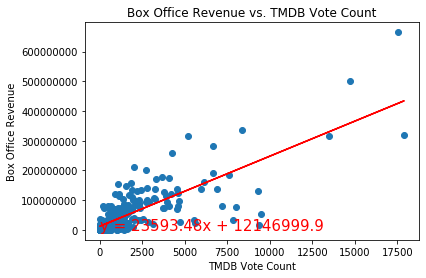

In [14]:
x_values = box_office_vote_count['vote_count']
y_values = box_office_vote_count['boxoffice']
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(0,50),fontsize=15,color="red")
plt.title('Box Office Revenue vs. TMDB Vote Count')
plt.xlabel('TMDB Vote Count')
plt.ylabel('Box Office Revenue')
#Turn off the scientific notation (ie8)
plt.ticklabel_format(style="Plain")
print(f"The r-squared is: {rvalue**2}")
plt.show()

In [15]:
#drop na from popularity and imdb rating columns:
popularity_clean = final_table_clean.dropna(subset=["popularity"])
popularity_imdb_rating_clean = popularity_clean.dropna(subset=["imdbrating"])

The r-squared is: 0.03456359923444159


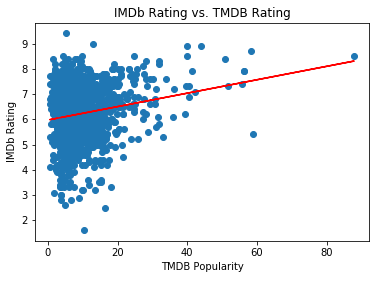

In [16]:
x_values = popularity_imdb_rating_clean['popularity']
y_values = popularity_imdb_rating_clean['imdbrating']
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(0,0),fontsize=15,color="red")
plt.title('IMDb Rating vs. TMDB Rating')
plt.xlabel('TMDB Popularity')
plt.ylabel('IMDb Rating')
print(f"The r-squared is: {rvalue**2}")
plt.show()

In [17]:
#drop na from metascore and imdb rating columns:
metascore_clean = final_table_clean.dropna(subset=["metascore"])
metascore_imdb_rating_clean = metascore_clean.dropna(subset=["imdbrating"])
metascore_imdb_rating_clean

,title,director,cast_members,year_released,netflix_genre,rating,duration,description,omdb_genre,language,awards,production,imdbrating,metascore,boxoffice,original_title,popularity,vote_count,vote_average,poster_path
2,Stonehearst Asylum,Brad Anderson,"Kate Beckinsale, Jim Sturgess, David Thewlis, ...",2014.0,"Horror Movies, Thrillers",PG-13,113 min,"In 1899, a young doctor arrives at an asylum f...","Drama, Horror, Thriller",English,1 win & 1 nomination.,Millenium Entertainment,6.8,52.0,NaN,Stonehearst Asylum,20.826,817.0,6.7,https://image.tmdb.org/t/p/w500/fZxGCCQ0NAtrae...
3,The Runner,Austin Stark,"Nicolas Cage, Sarah Paulson, Connie Nielsen, W...",2015.0,"Dramas, Independent Movies",R,90 min,A New Orleans politician finds his idealistic ...,Drama,English,NaN,Alchemy,4.7,39.0,NaN,The Runner,9.011,104.0,4.8,https://image.tmdb.org/t/p/w500/uIxFfrGlKEHJgk...
4,6 Years,Hannah Fidell,"Taissa Farmiga, Ben Rosenfield, Lindsay Burdge...",2015.0,"Dramas, Independent Movies, Romantic Movies",NR,80 min,As a volatile young couple who have been toget...,"Drama, Romance",English,4 nominations.,NaN,5.6,53.0,NaN,6 Years,6.515,594.0,5.5,na
7,Carrie Pilby,Susan Johnson,"Bel Powley, Nathan Lane, Vanessa Bayer, Gabrie...",2016.0,"Comedies, Dramas",TV-14,98 min,A socially awkward 19-year-old genius makes bi...,"Comedy, Drama",English,1 win & 2 nominations.,The Orchard,6.6,52.0,19025,Carrie Pilby,7.934,206.0,7.2,https://image.tmdb.org/t/p/w500/IHuNvCTOsSox1G...
10,Black Panther,Ryan Coogler,"Chadwick Boseman, Michael B. Jordan, Lupita Ny...",2018.0,"Action & Adventure, Sci-Fi & Fantasy",PG-13,135 min,"T'Challa, the superpowered new leader of the h...","Action, Adventure, Sci-Fi","English, Swahili, Nama, Xhosa, Korean",Won 3 Oscars. Another 109 wins & 265 nominations.,Marvel Studios,7.3,88.0,501105037,Black Panther,51.678,14711.0,7.4,https://image.tmdb.org/t/p/w500/uxzzxijgPIY7sl...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1405,xXx,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Action, Adventure, Thriller","English, German, Spanish, Russian, Czech",4 wins & 14 nominations.,Columbia Pictures,5.9,48.0,141134092,xXx,16.755,2755.0,5.9,https://image.tmdb.org/t/p/w500/wuqpGZsOQEVGJu...
1406,xXx: State of the Union,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Action, Adventure, Crime, Sci-Fi, Thriller",English,1 nomination.,Sony Pictures,4.4,37.0,26082914,xXx: State of the Union,17.469,1135.0,4.9,https://image.tmdb.org/t/p/w500/sNnciVEuolaZoI...
1410,I Don't Feel at Home in This World Anymore.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Comedy, Crime, Drama, Thriller",English,3 wins & 3 nominations.,Film Science,6.9,75.0,NaN,NaN,NaN,NaN,NaN,NaN
1413,It Comes At Night,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Horror, Mystery",English,1 win & 10 nominations.,A24,6.2,78.0,13985117,NaN,NaN,NaN,NaN,NaN


The r-squared is: 0.4117996177648912


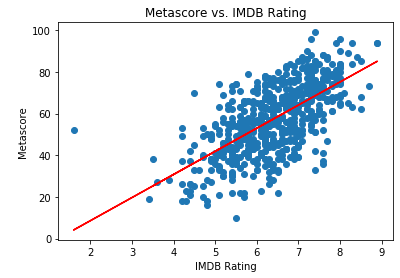

In [18]:
x_values = metascore_imdb_rating_clean['imdbrating']
y_values = metascore_imdb_rating_clean['metascore']
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(0,5),fontsize=15,color="red")
plt.title('Metascore vs. IMDB Rating')
plt.xlabel('IMDB Rating')
plt.ylabel('Metascore')
print(f"The r-squared is: {rvalue**2}")
plt.show()

In [19]:
#drop na from metascore and tmdb rating columns:
metascore_tmdb_rating_clean = metascore_clean.dropna(subset=["vote_average"])
metascore_tmdb_rating_clean

,title,director,cast_members,year_released,netflix_genre,rating,duration,description,omdb_genre,language,awards,production,imdbrating,metascore,boxoffice,original_title,popularity,vote_count,vote_average,poster_path
2,Stonehearst Asylum,Brad Anderson,"Kate Beckinsale, Jim Sturgess, David Thewlis, ...",2014.0,"Horror Movies, Thrillers",PG-13,113 min,"In 1899, a young doctor arrives at an asylum f...","Drama, Horror, Thriller",English,1 win & 1 nomination.,Millenium Entertainment,6.8,52.0,NaN,Stonehearst Asylum,20.826,817.0,6.7,https://image.tmdb.org/t/p/w500/fZxGCCQ0NAtrae...
3,The Runner,Austin Stark,"Nicolas Cage, Sarah Paulson, Connie Nielsen, W...",2015.0,"Dramas, Independent Movies",R,90 min,A New Orleans politician finds his idealistic ...,Drama,English,NaN,Alchemy,4.7,39.0,NaN,The Runner,9.011,104.0,4.8,https://image.tmdb.org/t/p/w500/uIxFfrGlKEHJgk...
4,6 Years,Hannah Fidell,"Taissa Farmiga, Ben Rosenfield, Lindsay Burdge...",2015.0,"Dramas, Independent Movies, Romantic Movies",NR,80 min,As a volatile young couple who have been toget...,"Drama, Romance",English,4 nominations.,NaN,5.6,53.0,NaN,6 Years,6.515,594.0,5.5,na
7,Carrie Pilby,Susan Johnson,"Bel Powley, Nathan Lane, Vanessa Bayer, Gabrie...",2016.0,"Comedies, Dramas",TV-14,98 min,A socially awkward 19-year-old genius makes bi...,"Comedy, Drama",English,1 win & 2 nominations.,The Orchard,6.6,52.0,19025,Carrie Pilby,7.934,206.0,7.2,https://image.tmdb.org/t/p/w500/IHuNvCTOsSox1G...
10,Black Panther,Ryan Coogler,"Chadwick Boseman, Michael B. Jordan, Lupita Ny...",2018.0,"Action & Adventure, Sci-Fi & Fantasy",PG-13,135 min,"T'Challa, the superpowered new leader of the h...","Action, Adventure, Sci-Fi","English, Swahili, Nama, Xhosa, Korean",Won 3 Oscars. Another 109 wins & 265 nominations.,Marvel Studios,7.3,88.0,501105037,Black Panther,51.678,14711.0,7.4,https://image.tmdb.org/t/p/w500/uxzzxijgPIY7sl...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1379,Best Worst Thing That Ever Could Have Happened...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Documentary,English,NaN,Atlas Media Corporation,7.7,81.0,104005,Best Worst Thing That Ever Could Have Happened...,2.643,9.0,8.0,https://image.tmdb.org/t/p/w500/kujZUKGnK4orpT...
1386,Tau,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Sci-Fi, Thriller",English,1 nomination.,Addictive Pictures,5.8,43.0,NaN,Tau,11.106,739.0,6.2,https://image.tmdb.org/t/p/w500/qqYOlCee3X7cKg...
1398,Who's That Knocking at My Door,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Drama, Romance",English,2 nominations.,WARNER BROTHERS PICTURES,6.7,63.0,NaN,Who's That Knocking at My Door,4.940,82.0,6.3,https://image.tmdb.org/t/p/w500/8RKE8nTCA69v9e...
1405,xXx,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Action, Adventure, Thriller","English, German, Spanish, Russian, Czech",4 wins & 14 nominations.,Columbia Pictures,5.9,48.0,141134092,xXx,16.755,2755.0,5.9,https://image.tmdb.org/t/p/w500/wuqpGZsOQEVGJu...


The r-squared is: 0.3236365404261393


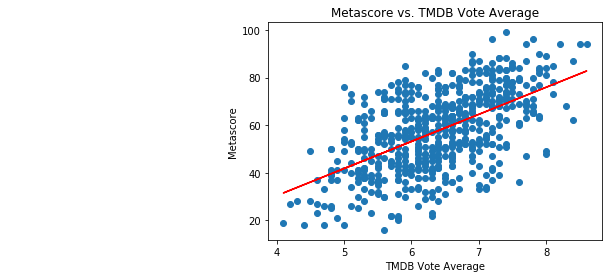

In [20]:
x_values = metascore_tmdb_rating_clean['vote_average']
y_values = metascore_tmdb_rating_clean['metascore']
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(0,50),fontsize=15,color="red")
plt.title('Metascore vs. TMDB Vote Average')
plt.xlabel('TMDB Vote Average')
plt.ylabel('Metascore')
print(f"The r-squared is: {rvalue**2}")
plt.show()